# Análisis de los datos de calidad del aire en Madrid

# Tabla de contenidos
1. [Introducción](#introduccion)
2. [Preparación de los datos](#preparacion)
    1. [Carga de ficheros y librerías](#carga)
        1. [Carga del CSV de estaciones de medida](#cargaestaciones)
        2. [Carga del CSV de códigos de los contaminantes](#cargacontaminantes)
        3. [Carga de datos de calidad del aire](#cargadatos)
    2. [Limpieza de ficheros](#limpieza)
3. [Análisis de los datos](#analisis)
    1. [Análisis en función del contaminante](#analisiscontaminante)
    2. [Análisis en función de las estaciones de medida](#analisisestaciones)
    3. [Análisis del efecto del protocolo anticontaminación](#analisisprotocolo)
4. [Conclusiones](#conclusiones)



# Introducción <a name="introduccion"></a>
El objetivo de esta PEC es realizar un análisis exploratorio de los datos históricos de calidad del aire en el municipio de Madrid. Los datasets están disponibles en la [página de datos abiertos](http://datos.madrid.es/sites/v/index.jsp?vgnextoid=aecb88a7e2b73410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD) del Ayuntamiento. En este trabajo se analizarán los datos de los últimos cinco años (Enero 2013-Diciembre 2017). 

Además de los datos de calidad del aire se utilizarán los siguientes ficheros auxiliares:
- `codigos_magnitudes.csv`: muestra la equivalencia entre el número de parámetro, el contaminante que representa y su abreviatura correspondiente. La tabla se ha extraído del [documento](http://datos.madrid.es/FWProjects/egob/contenidos/datasets/ficheros/Interprete_ficheros_%20calidad_%20del_%20aire_global.pdf) donde se describe el dataset.
- `informacion_estaciones_red_calidad_aire.csv`: contiene la situación de las estaciones de medida, así como la lista de  los contamintantes que miden. La [lista](http://datos.madrid.es/egob/catalogo/212629-0-estaciones-control-aire.xls) está disponible en la misma web de datos abiertos.

Estas son las preguntas que vamos a resolver:
- _¿Evolucionan igual los niveles de los contaminantes a lo largo del año?_
- _¿Los niveles de NO$_2$ son mayores en las estaciones del centro que en las de la periferia?_
- _¿Las medidas del protocolo anticontaminación tienen un efecto sustancial en los niveles de los contaminantes?_
- _¿Cómo afecta el clima en la concentración de los contaminantes?_

# Preparación de los datos <a name="preparacion"></a>
## Carga de librerías y ficheros <a name="carga"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
import re
import seaborn as sns 
import datetime as dt

%matplotlib inline

### Carga del CSV de estaciones de medida <a name="cargaestaciones"></a>

El CSV de estaciones de medida contiene información acerca de las 24 localizaciones donde se encuentran los aparatos de medida, así como la lista de sensores instalados.

Los tipos de estaciones son los siguientes:

| Tipo | Nombre            | Descripción                                                                                                                            | 
|------|:-------------------|:----------------------------------------------------------------------------------------------------------------------------------------| 
| __UT__   | Urbana de tráfico |  Zona edificada continua, la estación está influenciada principalmente por emisiones de tráfico en la calle o en una carretera próxima | 
| __UF__   | Urbana de fondo   |  Zona edificada continua, son estaciones que no están influenciadas ni por el tráfico ni por la industria                              | 
| __S__    | Suburbana         |  Zona continua de edificios separados combinada con zonas no urbanizadas                                                               | 

In [2]:
estaciones_medida = pd.read_csv("informacion_estaciones_red_calidad_aire.csv", 
                                sep=";", 
                                header=1,
                                dtype={'ESTACION': str})

estaciones_medida = estaciones_medida.iloc[:,:15] # Conservo solamente las 15 primeras columnas, 
                                                  # el resto contienen información sobre los sensores meteorológicos
estaciones_medida.head()

,ESTACION,NOMBRE ESTACION,DIRECCION,LONGITUD,LATITUD,ALTITUD,TIPO,NO2,SO2,CO,PM10,PM2.5,O3,BTX,HC
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635,UT,X,X,X,NaN,NaN,NaN,NaN,NaN
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670,UT,X,X,X,X,X,X,X,X
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708,UT,X,NaN,NaN,NaN,NaN,NaN,X,NaN
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693,UF,X,NaN,X,NaN,NaN,X,NaN,NaN
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604,UF,X,X,NaN,NaN,NaN,X,NaN,NaN


### Carga del CSV de códigos de los contaminantes <a name="cargacontaminantes"></a>
El fichero `codigos_magnitudes.csv` contiene la equivalencia entre el código de cada contaminante, su nombre, su abreviatura y las unidades en las que se expresa. Lo utilizaremos para obtener información adicional del contaminante a partir del código numérico del mismo.

In [3]:
codigos_magnitudes = pd.read_csv("codigos_magnitudes.csv", sep = ";")
codigos_magnitudes.head()

,PARAMETRO,MAGNITUD,ABREVIATURA,UNIDADES
0,1,Dióxido de Azufre,SO2,mg/m3
1,6,Monóxido de Carbono,CO,ug/m3
2,7,Monóxido de Nitrógeno,NO,ug/m3
3,8,Dióxido de Nitrógeno,NO2,ug/m3
4,9,Partículas < 2.5 um,"PM2,5",ug/m3


### Carga de datos de calidad del aire <a name="cargadatos"></a>

El portal del Ayuntamiento ofrece los datos de calidad del aire en dos formatos: horarios o diarios. En este trabajo utilizaremos los datos diarios del periodo Enero 2013 a Diciembre 2017, disponibles para su descarga agregados por años naturales.

Los ficheros de datos de calidad del aire contienen filas de información distribuida en los siguientes campos:
- Código estación (8 dígitos), compuesto por los siguientes campos: 
    - 28: código de la Comunidad de Madrid, común a todas las estaciones.
    - 079: código del municipio de Madrid, común a todas las estaciones.
    - XYZ: código de la estación.
- Parámetro (2 dígitos): indica el contaminante.
- Técnica analítica (2 dígitos): por ejemplo, absorción infrarroja o fluorescencia ultravioleta. No lo tendremos en cuenta en este trabajo, de manera que no importaremos esta columna.
- Tipo de análisis (2 dígitos): 04 (diario), común a todas las filas. No aporta información así que descartaremos la columna.
- Año: representado con 4 dígitos para 2017, y con dos dígitos para el resto de años.
- Mes (2 dígitos).
- Finalmente se incluyen 31 columnas (una por día del mes) junto con un caracter que indica si la lectura es válida (V) o no válida (N).


El fichero de datos de 2017 tiene un formato ligeramente diferente al del resto de ficheros. Se diferencia en lo siguiente:
- Su formato es CSV, mientras que el resto de años contienen filas con cadenas alfanuméricas sin separadores.
- El año está representado con 4 dígitos en lugar de 2.


Mostramos a continuación un extracto de dos ficheros para poder apreciar sus diferencias:

__Extracto del fichero CSV de 2017__:
<sub>                                                                                                                       
28,079,004,01,38,04,2017,01,00006,V,00008,V,00012,V,00009,V,00007,V,00010,V,00010,V,00011,V,00010,V,00012,V,00011,V,00008,V,00006,V,00007,V,00007,V,00009,V,00006,V,00005,V,00005,V,00005,V,00006,V,00007,V,00009,V,00012,V,00009,V,00009,V,00005,V,00004,V,00004,V,00005,V,00007,V
28,079,004,01,38,04,2017,**02**,00008,V,00004,V,00003,V,00003,V,00003,V,00004,V,00005,V,00005,V,00006,V,00008,V,00005,V,00004,V,00004,V,00006,V,00006,V,00007,V,00009,V,00008,V,00006,V,00007,V,00009,V,00012,V,00011,V,00006,V,00006,V,00005,V,00004,V,00004,V,**00000,N,00000,N,00000,N**
28,079,004,01,38,04,2017,03,00005,V,00007,V,00005,V,00003,V,00003,V,00004,V,00006,V,00009,V,00010,V,00010,V,00007,V,00005,V,00004,V,00005,V,00005,V,00005,V,00007,V,00008,V,00007,V,00006,V,00005,V,00004,V,00003,V,00004,V,00004,V,00004,V,00004,V,00005,V,00007,V,00007,V,00005,V                                                                                         
...
</sub>


__Extracto del fichero de 2016__:
<sub>  
28079004013804160100008V00007V00006V00006V00007V00006V00006V00006V00006V00006V00006V00007V00011V00008V00008V00009V00009V00008V00011V00010V00009V00010V00011V00011V00013V00012V00009V00007V00008V00009V00009V
2807900401380416**02**00012V00013V00009V00009V00011V00009V00007V00007V00007V00007V00007V00007V00007V00007V00007V00008V00008V00007V00009V00011V00010V00011V00010V00009V00008V00007V00007V00008V00009V**00000N00000N**
28079004013804160300011V00010V00009V00009V00007V00008V00008V00008V00009V00008V00009V00009V00009V00008V00009V00011V00010V00009V00007V00007V00008V00008V00008V00009V00009V00009V00008V00007V00008V00010V00008V
...
</sub>

Vamos a analizar el sentido de expresar las medidas de cada día junto con su caracter de validez. Vemos que la tabla siempre reporta valores para 31 días independientemente del mes, de modo que existen valores para el 30 de febrero o el 31 de abril, por ejemplo. Comprobamos que estos casos se marcan con una "N" y su valor es cero (marcado en negrita en la segunda fila de ambos extractos, correspondiente al mes de febrero). 

En nuestro caso, durante la fase de importación y limpieza de los datos vamos a reorganizar las tablas de manera que cada fila corresponda una única observación de un contaminante por estación y día. Podremos prescindir de los caracteres de validez, ya que es trivial distinguir qué datos son válidos para un mes, y qué datos no lo son. Para simplificar el proceso, no importaremos las columnas con el caracter de validez y posteriormente aplicaremos filtros para descartar valores no válidos.

#### Fichero de datos de 2017

In [4]:
# Creo etiquetas para las columnas de los días: ['D1', 'D2', 'D3', ...'D31']
dias = ["D" + str(i) for i in range(1,32)]

# Genero una lista de indices de las columnas que quiero conservar. Descarto las columnas de Técnica y Tipo de análisis, 
# y prescindo del caracter de validez seleccionando las columnas de índice par a partir de la octava
columnas = [0, 1, 2, 3, 6, 7] + list(range(8,69,2))

# Lista con los nombres de las columnas
nombres = ["CE1", "CE2", "CE3", "PARAMETRO", "AÑO", "MES"] + dias

calidad_aire_2017 = pd.read_csv("datos17.txt", 
                                header=None, 
                                usecols=columnas,
                                names=nombres,
                                dtype= {'CE1': str, 'CE2': str, 'CE3': str} # Evito que pierda el cero a la izquierda
                               )

# Concateno las tres primeras columnas para componer el código completo de la estación de medida
calidad_aire_2017["ESTACION"] = calidad_aire_2017["CE1"] + calidad_aire_2017["CE2"] + calidad_aire_2017["CE3"]
calidad_aire_2017.head()

,CE1,CE2,CE3,PARAMETRO,AÑO,MES,D1,D2,D3,D4,...,D23,D24,D25,D26,D27,D28,D29,D30,D31,ESTACION
0,28,079,004,1,2017,1,6.0,8.0,12.0,9.0,...,9.0,12.0,9.0,9.0,5.0,4.0,4.0,5.0,7.0,28079004
1,28,079,004,1,2017,2,8.0,4.0,3.0,3.0,...,11.0,6.0,6.0,5.0,4.0,4.0,0.0,0.0,0.0,28079004
2,28,079,004,1,2017,3,5.0,7.0,5.0,3.0,...,3.0,4.0,4.0,4.0,4.0,5.0,7.0,7.0,5.0,28079004
3,28,079,004,1,2017,4,4.0,4.0,5.0,7.0,...,5.0,6.0,4.0,4.0,3.0,4.0,4.0,4.0,0.0,28079004
4,28,079,004,1,2017,5,4.0,5.0,5.0,6.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,28079004


In [5]:
# Descarto las columnas CE1, CE2 y CE3
calidad_aire_2017.drop(["CE1", "CE2", "CE3"], axis=1, inplace=True)

# Modifico el año para que tenga dos cifras en lugar de cuatro
calidad_aire_2017["AÑO"] = 17
calidad_aire_2017.head()

,PARAMETRO,AÑO,MES,D1,D2,D3,D4,D5,D6,D7,...,D23,D24,D25,D26,D27,D28,D29,D30,D31,ESTACION
0,1,17,1,6.0,8.0,12.0,9.0,7.0,10.0,10.0,...,9.0,12.0,9.0,9.0,5.0,4.0,4.0,5.0,7.0,28079004
1,1,17,2,8.0,4.0,3.0,3.0,3.0,4.0,5.0,...,11.0,6.0,6.0,5.0,4.0,4.0,0.0,0.0,0.0,28079004
2,1,17,3,5.0,7.0,5.0,3.0,3.0,4.0,6.0,...,3.0,4.0,4.0,4.0,4.0,5.0,7.0,7.0,5.0,28079004
3,1,17,4,4.0,4.0,5.0,7.0,4.0,4.0,5.0,...,5.0,6.0,4.0,4.0,3.0,4.0,4.0,4.0,0.0,28079004
4,1,17,5,4.0,5.0,5.0,6.0,5.0,4.0,4.0,...,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,28079004


#### Ficheros de datos de 2013 a 2016
En este caso los ficheros se componen de líneas de caracteres alfanuméricos sin separador. Podemos utilizar como separadores los caracteres de validez V y N. 

Existe un tercer caracter de validez "M" que no aparece descrito en la documentación. Se encuentra presente solamente en 12 líneas, así que podemos interpretar que los datos marcados como "M" no son válidos. Los descartaremos durante la fase de lectura de los ficheros.

Al utilizar los caracteres de validez como separadores de columnas, se importará una primera columna con los datos de la estación, el contaminante, y el resto de la información junto con el dato del día D1: 

| INFO+D1                 | D2  | D3  | D4   | D5  | D6  | D7  | D8  | D9  | D10 | ... | D27 | D28 | D29 | D30  | D31  |  
|-------------------------|-----|-----|------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|----------|-----------|-----|-----|-----| 
| 28079004013804130100004 | 8.0 | 8.0 | 11.0 | 9.0 | 9.0 | 5.0 | 5.0 | 5.0 | 6.0 | ... | 5.0 | 5.0 | 9.0 | 10.0 | 10.0 |  



Posteriormente procesaremos la primera columna para separar los datos que queremos conservar.

In [6]:
# Combino los ficheros anuales en uno para procesarlos juntos
filenames = ['datos13.txt', 'datos14.txt', 'datos15.txt', 'datos16.txt']

with open('datos13-16.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not re.match("(.*)(M|m)(.*)", line): # Compruebo que la linea no contiene el caracter "M"
                    outfile.write(line)  

In [7]:
# Creo etiquetas para las columnas de los días, empezando en el segundo: ['D2', 'D3', ...'D31']
dias = ["D" + str(i) for i in range(2,32)]

# Etiquetas para las columnas:
nombres = ["INFO+D1"] + dias

# Genero una lista de indices de las columnas que quiero conservar. 
# Descarto la última, ya que read_csv interpreta que hay datos después del último separador y crea una columna NaN
columnas = range(0,len(nombres))

calidad_aire_2013_2016 = pd.read_csv("datos13-16.txt", 
                               header=None, 
                               usecols=columnas,
                               names=nombres,
                               sep="V|N",
                               engine='python'                               
                           )

calidad_aire_2013_2016.head()

,INFO+D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31
0,28079004013804130100004,8.0,8.0,11.0,9.0,9.0,5.0,5.0,5.0,6.0,...,3.0,5.0,5.0,5.0,6.0,5.0,5.0,9.0,10.0,10.0
1,28079004013804130200005,5.0,5.0,8.0,8.0,5.0,5.0,6.0,5.0,4.0,...,3.0,4.0,5.0,5.0,6.0,5.0,4.0,0.0,0.0,0.0
2,28079004013804130300005,5.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,...,5.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,28079004013804130400003,3.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,...,3.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0,5.0,0.0
4,28079004013804130500004,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,...,4.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0


In [8]:
# Extraigo de 'INFO+D1' los siguientes datos:
calidad_aire_2013_2016["ESTACION"] = calidad_aire_2013_2016["INFO+D1"].str[0:8]
calidad_aire_2013_2016["PARAMETRO"] = calidad_aire_2013_2016["INFO+D1"].str[8:10].astype(int)
calidad_aire_2013_2016["AÑO"] = calidad_aire_2013_2016["INFO+D1"].str[14:16].astype(int)
calidad_aire_2013_2016["MES"] = calidad_aire_2013_2016["INFO+D1"].str[16:18].astype(int)
calidad_aire_2013_2016["D1"] = calidad_aire_2013_2016["INFO+D1"].str[18:].astype(float)

# Descarto la columna 'INFO+D1'
calidad_aire_2013_2016.drop(["INFO+D1"], inplace=True, axis=1)

calidad_aire_2013_2016.head()

,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,D27,D28,D29,D30,D31,ESTACION,PARAMETRO,AÑO,MES,D1
0,8.0,8.0,11.0,9.0,9.0,5.0,5.0,5.0,6.0,4.0,...,5.0,5.0,9.0,10.0,10.0,28079004,1,13,1,4.0
1,5.0,5.0,8.0,8.0,5.0,5.0,6.0,5.0,4.0,4.0,...,5.0,4.0,0.0,0.0,0.0,28079004,1,13,2,5.0
2,5.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,28079004,1,13,3,5.0
3,3.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,4.0,5.0,0.0,28079004,1,13,4,3.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,...,4.0,3.0,3.0,3.0,3.0,28079004,1,13,5,4.0


In [9]:
# Una vez procesados ambos ficheros, concatenamos uno con otro para trabajar con un único dataframe
calidad_aire = pd.concat([calidad_aire_2013_2016, calidad_aire_2017])

calidad_aire.head()

,AÑO,D1,D10,D11,D12,D13,D14,D15,D16,D17,...,D31,D4,D5,D6,D7,D8,D9,ESTACION,MES,PARAMETRO
0,13,4.0,6.0,4.0,3.0,3.0,5.0,5.0,3.0,4.0,...,10.0,11.0,9.0,9.0,5.0,5.0,5.0,28079004,1,1
1,13,5.0,4.0,4.0,5.0,7.0,8.0,7.0,8.0,6.0,...,0.0,8.0,8.0,5.0,5.0,6.0,5.0,28079004,2,1
2,13,5.0,3.0,3.0,3.0,4.0,5.0,5.0,4.0,3.0,...,3.0,4.0,4.0,4.0,3.0,3.0,3.0,28079004,3,1
3,13,3.0,3.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,...,0.0,3.0,4.0,4.0,3.0,3.0,3.0,28079004,4,1
4,13,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,...,3.0,4.0,4.0,4.0,4.0,4.0,4.0,28079004,5,1


## Limpieza de ficheros <a name="limpieza"></a>
Es necesario realizar una limpieza y una reorganización de los datos del fichero de calidad del aire. Las tareas que se van a realizar son las siguientes:
- Reorganizar los datos de manera que cada fila corresponda a una observación. Vemos que cada fila siempre contiene 31 valores correspondientes a cada día del mes, utilizaremos la función `melt` para separar las mediciones de cada día en filas independientes.
- Combinar las columnas `AÑO`, `MES` y `DIA` para crear una columna `FECHA`.
- Descartar los valores no válidos. Cada fila muestra 31 medidas, independientemente del número de días de cada mes (28, 30 o 31). Aplicaremos un filtro para eliminarlos.

In [10]:
calidad_aire = pd.melt(calidad_aire, # Reorganizamos los datos en filas con una observación por fecha, estación y parámetro
                       id_vars=["ESTACION", "PARAMETRO", "AÑO", "MES"], 
                       var_name="DIA", 
                       value_name="VALOR")
calidad_aire.head()

,ESTACION,PARAMETRO,AÑO,MES,DIA,VALOR
0,28079004,1,13,1,D1,4.0
1,28079004,1,13,2,D1,5.0
2,28079004,1,13,3,D1,5.0
3,28079004,1,13,4,D1,3.0
4,28079004,1,13,5,D1,4.0


In [11]:
# Elimino la "D" de la columna DIA y lo convierto a int
calidad_aire["DIA"] = calidad_aire["DIA"].map(lambda x: str(x)[1:]).astype(int) 

# Descarto los valores no válidos para Febrero (DIA > 28), teniendo en cuenta que 2016 fue un año bisiesto
calidad_aire.drop(calidad_aire[(calidad_aire["MES"] == 2) & 
                               (calidad_aire["DIA"] > 28) &
                               (calidad_aire["AÑO"] != 16)].index, inplace = True)

calidad_aire.drop(calidad_aire[(calidad_aire["MES"] == 2) & 
                               (calidad_aire["DIA"] > 29) &
                               (calidad_aire["AÑO"] == 16)].index, inplace = True)

# Descarto los días 31 en los meses de Abril, Junio, Septiembre y Noviembre
calidad_aire.drop(calidad_aire[((calidad_aire["MES"] == 4) & (calidad_aire["DIA"] == 31) ) | 
                               ((calidad_aire["MES"] == 6) & (calidad_aire["DIA"] == 31) ) |  
                               ((calidad_aire["MES"] == 9) & (calidad_aire["DIA"] == 31) ) | 
                               ((calidad_aire["MES"] == 11)) & (calidad_aire["DIA"] == 31)].index, inplace = True)

In [12]:
# Creo una nueva columna con la fecha completa en el formato YYYY-MM-DD
calidad_aire['FECHA'] = pd.to_datetime(calidad_aire['AÑO'].astype(str) +  
                                       calidad_aire['MES'].astype(str) +  
                                       calidad_aire['DIA'].astype(str), 
                                       format='%y%m%d')

# Descarto AÑO, MES y DIA, y ordeno por fecha
calidad_aire.drop(["AÑO", "MES", "DIA"], axis = 1, inplace = True)
calidad_aire.sort_values(by='FECHA', inplace = True)

calidad_aire.head()

,ESTACION,PARAMETRO,VALOR,FECHA
0,28079004,1,4.0,2013-01-01
480,28079024,9,7.0,2013-01-01
492,28079024,10,7.0,2013-01-01
504,28079024,14,27.0,2013-01-01
516,28079024,20,0.9,2013-01-01


A continuación añado los abreviaturas de cada parámetro para poder identificarlos por su nombre. También incluyo los nombres de las estaciones y su tipo. Finalmente, modifico el índice del dataframe para que sea la fecha, de manera que pueda utilizarlo como eje X con facilidad.

In [13]:
calidad_aire = calidad_aire.merge(codigos_magnitudes[['PARAMETRO', 'ABREVIATURA', 'UNIDADES']], on='PARAMETRO', how='left')
calidad_aire = calidad_aire.merge(estaciones_medida[['ESTACION','NOMBRE ESTACION', 'TIPO']], on = 'ESTACION', how='left')
calidad_aire.set_index('FECHA', inplace=True)
calidad_aire.head()

,ESTACION,PARAMETRO,VALOR,ABREVIATURA,UNIDADES,NOMBRE ESTACION,TIPO
FECHA,,,,,,,
2013-01-01,28079004,1,4.0,SO2,mg/m3,Pza. de España,UT
2013-01-01,28079024,9,7.0,"PM2,5",ug/m3,Casa de Campo,S
2013-01-01,28079024,10,7.0,PM10,ug/m3,Casa de Campo,S
2013-01-01,28079024,14,27.0,O3,ug/m3,Casa de Campo,S
2013-01-01,28079024,20,0.9,TOL,ug/m3,Casa de Campo,S


## Análisis de los datos <a name="analisis"></a>

### Análisis en función del contaminante <a name="analisiscontaminante"></a>
En este apartado queremos responder la siguiente pregunta: 
    _¿Evolucionan igual los niveles de los contaminantes a lo largo del año?_

Para ver la evolución de un contaminante a lo largo del año calculo las medias de los valores para cada mes a lo largo de los cinco años del dataset. A continuación preparo subplots en función de las unidades de medida (separando $\mu$g/m$^3$ de mg/m$^3$) para que los gráficos sean coherentes. 

In [14]:
# Separo el dataset en función de las unidades de medida
calidad_aire_ug = calidad_aire[calidad_aire['UNIDADES'] == "ug/m3"]
calidad_aire_mg = calidad_aire[calidad_aire['UNIDADES'] == "mg/m3"]

# Preparo los datos en forma de pivot table para poder representarlos en forma de heatmap
calidad_parametro_mes_ug = pd.pivot_table(calidad_aire_ug, 
                                          values='VALOR', 
                                          index='ABREVIATURA', 
                                          columns=calidad_aire_ug.index.month, 
                                          aggfunc=np.mean)

calidad_parametro_mes_ug.columns = ['ENE','FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

calidad_parametro_mes_mg = pd.pivot_table(calidad_aire_mg, 
                                          values='VALOR', 
                                          index='ABREVIATURA', 
                                          columns=calidad_aire_mg.index.month, 
                                          aggfunc=np.mean)

calidad_parametro_mes_mg.columns = ['ENE','FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

# Ejemplo del formato de uno de los dataframes:
calidad_parametro_mes_ug.head()

,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
ABREVIATURA,,,,,,,,,,,,
BEN,1.167179,0.730024,0.630430,0.444556,0.386667,0.405517,0.456285,0.385651,0.568391,0.829378,0.947778,1.134132
CO,0.524615,0.383546,0.362839,0.310800,0.280000,0.257133,0.250000,0.244129,0.308733,0.398452,0.452308,0.520500
EBE,0.815385,0.432270,0.467957,0.352222,0.783011,0.464138,0.383537,0.374194,0.515632,0.720507,0.713846,0.804448
NO,55.796154,28.567376,17.352151,9.911389,8.359946,7.369167,7.563441,32.588172,14.372222,29.418011,38.485897,56.790417
NO2,52.440385,37.532506,37.103226,29.655000,28.004032,28.339444,30.655645,26.768548,37.921944,45.997849,47.938248,55.439792


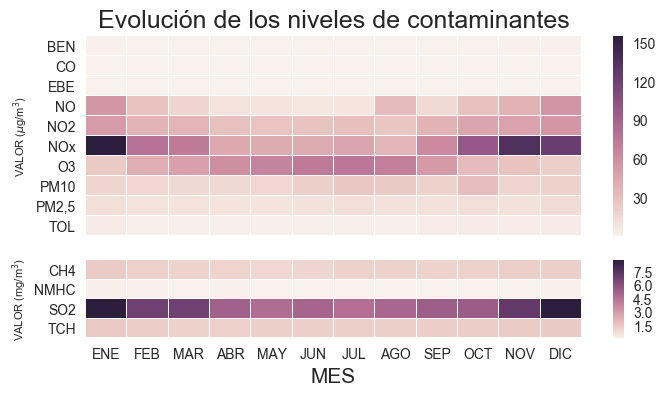

In [15]:
# Dibujo los heatmaps a partir de las pivot tables
fig1 = plt.figure(figsize=(8,4), dpi=100)

ax1 = plt.subplot2grid((15,2),(0,0), rowspan=10, colspan=2)
ax2 = plt.subplot2grid((15,2),(11,0), rowspan=4, colspan=2)

# Primer subplot: datos expresados en μg/m3
ax1 = sns.heatmap(calidad_parametro_mes_ug,
                  square=False,  
                  linewidths=0.1,                   
                  ax=ax1)  

ax1.set_title('Evolución de los niveles de contaminantes', fontsize=18);
ax1.set_ylabel(r'VALOR ($\mu$g/m$^3$)', fontsize=8)
ax1.xaxis.set_visible(False)

# Segundo subplot: datos expresados en mg/m3
ax2 = sns.heatmap(calidad_parametro_mes_mg,
                  square=False,  
                  linewidths=0.1, 
                  ax=ax2,
                  cbar_kws={"aspect": 7} # Controla la anchura del colorbar
                 )  

ax2.set_ylabel(r'VALOR (mg/m$^3$)', fontsize=8)

ax2.xaxis.set_label_position('bottom')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('MES', fontsize=15);


Podemos comprobar que en general los niveles de cada contaminante no varían demasiado a lo largo del año excepto en los siguientes casos:
- Los óxidos de nitrógeno (NO, NO2, NOX) y de azufre (SO2) muestran niveles muy superiores durante los meses de otoño e invierno. Este incremento se debe fundamentalmente al efecto de las calefacciones.
- El ozono (O3) sigue un ciclo inverso al resto, con valores más altos durante el verano. Esto se debe a que el ozono se forma en los meses de calor cerca de la superficie terrestre, por efecto combinado de la radiación solar y las emisiones de la combustión de carbón, petróleo o gas.

Otra característica particular del ozono es que éste se acumula a una cierta distancia de las fuentes de sus precursores, por lo que paradójicamente afecta mucho más a las zonas rurales y periurbanas que a las ciudades. Comprobamos si esta hipótesis es cierta a partir de nuestro dataset comparando la evolución del ozono y el dióxido de nitrógeno.

In [16]:
# Creo dataframes que contienen solamente los datos de O3
calidad_aire_O3 = calidad_aire[calidad_aire['ABREVIATURA'] == "O3"]
calidad_O3_mes = pd.pivot_table(calidad_aire_O3, 
                                values='VALOR', 
                                index='TIPO', 
                                columns=calidad_aire_O3.index.month,
                                aggfunc=np.mean)

calidad_aire_NO2 = calidad_aire[(calidad_aire['ABREVIATURA'] == "NO2")]
calidad_NO2_mes = pd.pivot_table(calidad_aire_NO2, 
                                values='VALOR', 
                                index='TIPO', 
                                columns=calidad_aire_NO2.index.month,
                                aggfunc=np.mean)

# Ejemplo del formato de uno de los dataframes:
calidad_O3_mes.head()

FECHA,1,2,3,4,5,6,7,8,9,10,11,12
TIPO,,,,,,,,,,,,
S,28.687179,46.586288,54.756989,65.504444,73.722581,81.577778,83.806452,77.432258,60.960000,38.384946,36.423932,27.008333
UF,23.794231,40.017730,48.194355,59.156667,66.620968,74.702500,76.344355,69.901613,52.685000,32.093548,26.978205,20.853750
UT,21.958974,37.699764,45.713978,55.871111,61.227957,65.120000,67.083871,64.051613,47.008889,27.352688,23.613675,18.871667


In [17]:
calidad_O3_mes = calidad_O3_mes.T
calidad_NO2_mes = calidad_NO2_mes.T

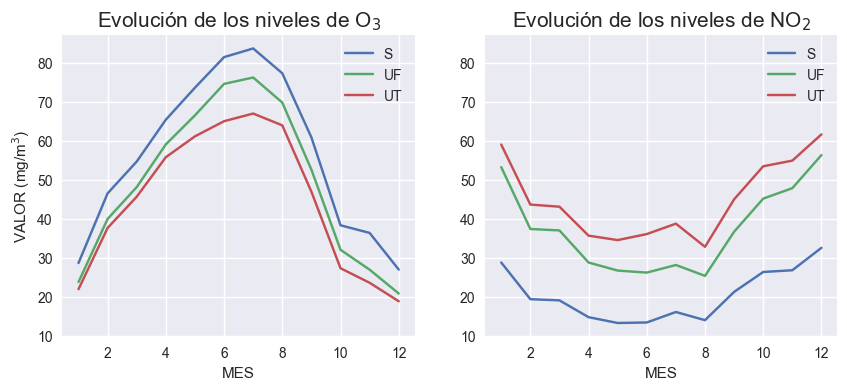

In [18]:
plt.figure(figsize=(10,4), dpi=100)

fig1 = plt.subplot(1, 2, 1)
plt.plot(calidad_O3_mes['S'].index, calidad_O3_mes['S'].values, label='S')
plt.plot(calidad_O3_mes['UF'].index, calidad_O3_mes['UF'].values, label='UF')
plt.plot(calidad_O3_mes['UT'].index, calidad_O3_mes['UT'].values, label='UT')
plt.legend();
plt.xlabel('MES')
plt.ylabel(r'VALOR (mg/m$^3$)')
fig1.set_title('Evolución de los niveles de O$_3$', fontsize=15);

fig2 = plt.subplot(1, 2, 2, sharey = fig1)
plt.plot(calidad_NO2_mes['S'].index, calidad_NO2_mes['S'].values, label='S')
plt.plot(calidad_NO2_mes['UF'].index, calidad_NO2_mes['UF'].values, label='UF')
plt.plot(calidad_NO2_mes['UT'].index, calidad_NO2_mes['UT'].values, label='UT')
plt.legend();
plt.xlabel('MES')
fig2.set_title('Evolución de los niveles de NO$_2$', fontsize=15);

Comprobamos que la concentración de ozono en las estaciones suburbanas es siempre superior a los niveles de las estaciones urbanas de tráfico y urbanas de fondo. Por otra parte, en todas las estaciones se cumple que los valores máximos se producen durante los meses de verano. 

La evolución del dióxido de nitrógeno sigue un patrón contrario al del ozono, ya que su concentración disminuye en los meses de verano y es más significativa en las estaciones urbanas que en las que están alejadas del centro.

### Análisis en función de las estaciones de medida <a name="analisisestaciones"></a>
A partir de este punto nos centraremos en el análisis del __dióxido de nitrógeno__ (NO$_2$), ya que es uno de los contaminantes más dañinos y cuyos niveles suelen provocar la activación de protocolos anticontaminación en el municipio de Madrid. Estas son las preguntas que queremos resolver en esta sección:
- _¿Los niveles de NO$_2$ son mayores en las estaciones del centro que en las de la periferia?_

Ya que los niveles de NO$_2$ están muy relacionados con las emisiones de tráfico, parece lógico suponer que las estaciones urbanas tendrán unas medidas superiores a las suburbanas. En efecto, si calculamos la media total agrupando por tipo de estación vemos que la media de las estaciones urbanas prácticamente duplica a las suburbanas, ya que éstas últimas no están tan expuestas al tráfico.

In [19]:
calidad_aire_NO2.groupby(['TIPO'])['VALOR'].mean()

TIPO
S     20.571924
UF    37.431681
UT    44.944079
Name: VALOR, dtype: float64

Creamos un dataframe auxiliar con la media de la concentración de NO$_2$ particularizada para cada estación. Agregamos también sus coordenadas y su tipo para poder verlo de manera gráfica sobre un mapa.

In [20]:
estaciones_valores = pd.DataFrame(calidad_aire_NO2.groupby(['NOMBRE ESTACION'])['VALOR'].mean())
estaciones_valores.reset_index(inplace = True)
estaciones_valores = estaciones_valores.merge(estaciones_medida[['NOMBRE ESTACION', 'LONGITUD', 'LATITUD', 'TIPO']], on = 'NOMBRE ESTACION', how = 'left')
estaciones_valores.head()

,NOMBRE ESTACION,VALOR,LONGITUD,LATITUD,TIPO
0,Arturo Soria,38.538335,-3.639233,40.440047,UF
1,Avda. Ramón y Cajal,44.023549,-3.677356,40.451475,UT
2,Barajas Pueblo,34.818729,-3.580031,40.476928,UF
3,Barrio del Pilar,41.829682,-3.711542,40.478228,UT
4,Casa de Campo,22.219606,-3.747347,40.419356,S


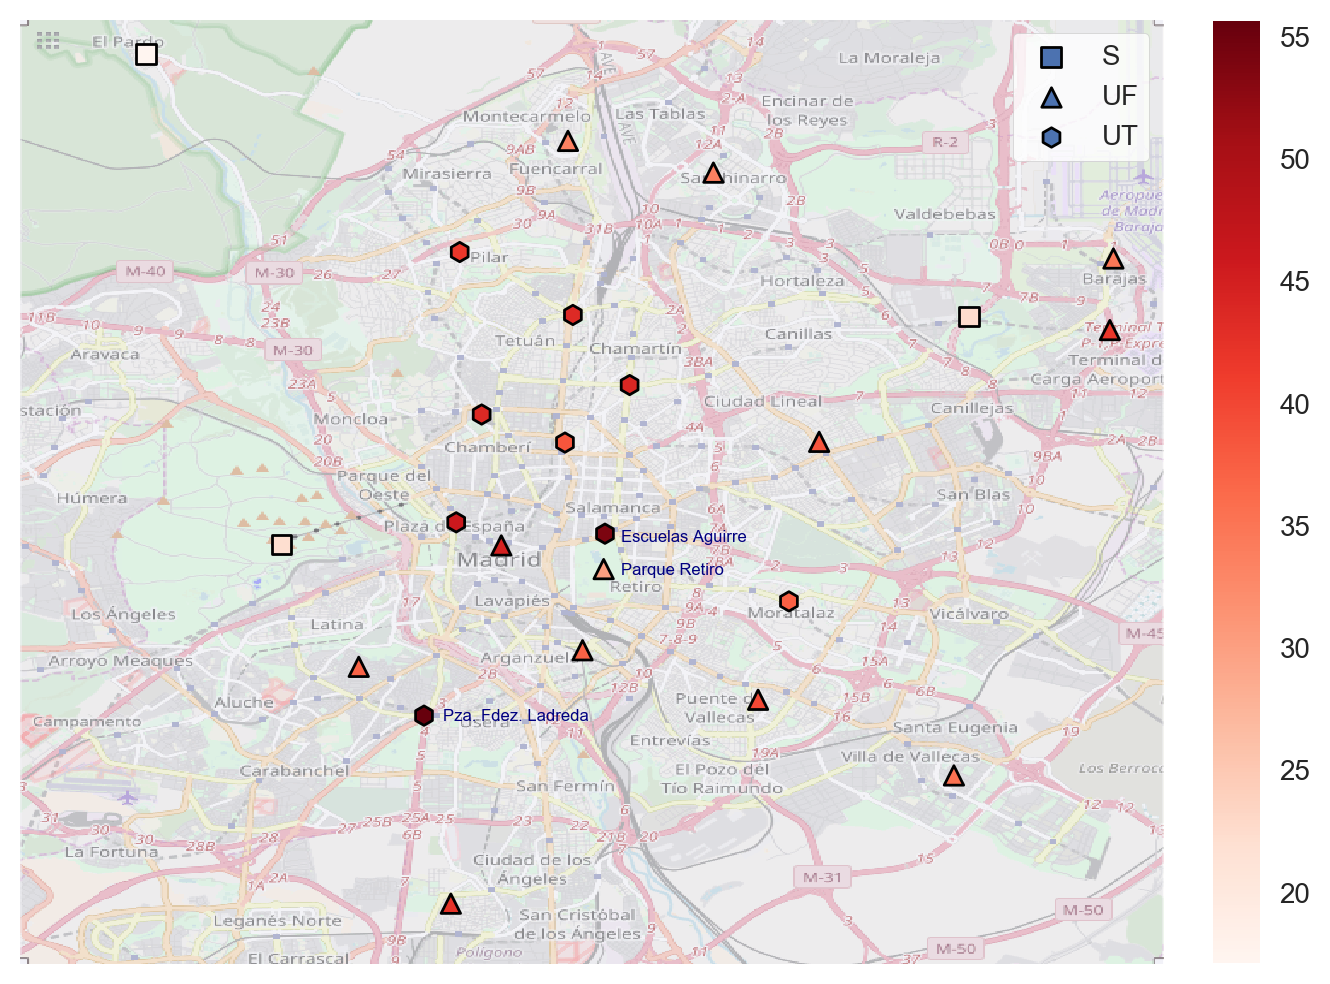

In [21]:
# Cargamos una imagen con el mapa de Madrid extraída de OpenStreetMap. 
# Durante el proceso hemos tomado nota de las coordenadas de los extremos.
madrid_img = mpimg.imread('madrid.png')

fig = plt.figure(figsize=(8,12), dpi=200)
ax = fig.gca() # gca = get current axes

# imshow muestra una imagen en los ejes
ax.imshow(madrid_img, 
          extent=[-3.800, -3.5700, 40.3350, 40.5250], # Localización de la esquina inferior izquierda y superior derecha,
                                                      # a partir de las coordenadas de OpenStreetMaps
          alpha=0.5) 

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

tipos_estaciones = ['S', 'UF', 'UT']
markers = ["s", "^", "h"]

# El bucle dibuja cada grupo de estaciones aplicando un marker diferente en función del tipo (S, UF o UT)
# vmax y vmin controlan que cada grupo se coloree en base al mismo colormap para todas las iteraciones
for i in [0, 1, 2]:
    data = estaciones_valores[estaciones_valores['TIPO'] == tipos_estaciones[i]]
    marker = markers[i]
    sc = ax.scatter(x=data['LONGITUD'], 
                    y=data['LATITUD'], 
                    c=data['VALOR'],
                    vmin=estaciones_valores['VALOR'].min(),
                    vmax=estaciones_valores['VALOR'].max(),
                    cmap='Reds', 
                    marker=marker,
                    linewidths=1,
                    edgecolors='black',
                    label=tipos_estaciones[i]
               )
    
ax.annotate('Pza. Fdez. Ladreda', 
            xy=(-3.715, 40.384), 
            size=6,
            color='navy')

ax.annotate('Escuelas Aguirre', 
            xy=(-3.679, 40.42), 
            size=6,
            color='navy')

ax.annotate('Parque Retiro', 
            xy=(-3.679, 40.4133), 
            size=6,
            color='navy')

cbar = fig.colorbar(sc, fraction=0.038, pad=0.04)
legend = plt.legend(frameon=True)
legend.get_frame().set_facecolor('white')

En el mapa podemos observar que las estaciones suburbanas son las que miden los niveles más bajos y que en general las estaciones urbanas, ya sean de tráfico o de fondo, tienen los valores más altos de NO$_2$. Podemos destacar los siguientes casos particulares:
- La Plaza Fernández Ladreda es una de las zonas más contaminadas, a pesar de que está muy alejada del centro de la ciudad. 
- Las estaciones de Escuelas Aguirre y del Parque del Retiro están muy próximas entre sí, aunque sus niveles son muy diferentes (53.97$\mu$g/m$^3$ vs 30.16$\mu$g/m$^3$).

A la vista del mapa, podemos concluir que el nivel de contaminación que mide una estación no depende necesariamente de su cercanía al centro, ya que hay estaciones en la periferia cuyos niveles son muy superiores a otras situadas en el centro. Los altos niveles parecen estar relacionados con la cercanía de la estación a autovías o nudos de comunicación importantes.

### Análisis del efecto del protocolo anticontaminación <a name="analisisprotocolo"></a>

El Ayuntamiento de Madrid monitoriza los niveles de dióxido de nitrógeno, dióxido de azufre y ozono, y en ocasiones activa una serie de medidas si las concentraciones superan los valores establecidos por la Unión Europea. Durante 2017 hubo un total de seis episodios por alta contaminación de NO$_2$, cinco de los cuales se produjeron después del verano. El listado completo de episodios se puede consultar [aquí](http://www.mambiente.munimadrid.es/opencms/opencms/calaire/Episodios/Informes_episodios.html). 

El protocolo anticontaminación consta de diferentes escenarios según la gravedad del episodio; todos los escenarios consisten fundamentalmente en la reducción de la velocidad máxima en ciertas vías así como restricciones y prohibiciones en el estacionamiento de los vehículos. El objetivo que se persigue es reducir las emisiones de los vehículos para que disminuyan los niveles de los contaminantes en el aire. Las preguntas que nos planteamos en este apartado se muestran a continuación:

_¿Las medidas del protocolo anticontaminación tienen un efecto sustancial en los niveles de los contaminantes?_

_¿Cómo afecta el clima en la concentración de los contaminantes?_

Para este apartado vamos a particularizar el análisis en la estación que midió los niveles más altos de concentración de NO2 durante 2017, Escuelas Aguirre. Filtramos los datos correspondientes a esta estación a partir de septiembre de 2017 para poder observar los cinco episodios que se produjeron en los últimos meses del año.

In [22]:
calidad_NO2_2017 = calidad_aire_NO2[(calidad_aire_NO2.index >= "2017-01-01")].groupby('NOMBRE ESTACION')['VALOR'].mean()
calidad_NO2_2017.sort_values(ascending=False).head(1)

NOMBRE ESTACION
Escuelas Aguirre    61.827397
Name: VALOR, dtype: float64

In [23]:
calidad_NO2_2017_escuelas = calidad_aire_NO2[(calidad_aire_NO2.index >= "2017-09-01") & 
                                             (calidad_aire_NO2['NOMBRE ESTACION'] == 'Escuelas Aguirre')]['VALOR']

Cargamos un CSV auxiliar que contiene los datos del clima durante los meses de septiembre a diciembre de 2017. Los datos se han obtenido de la web [TuTiempo.net](https://www.tutiempo.net/clima/2017/ws-82210.html).

In [24]:
tiempo_Sept_Dic_2017 = pd.read_csv("tiempo_Sept_Dic_2017.csv", 
                                   sep = ";", 
                                   na_values="-")

# Convierto 'Fecha' a formato datetime y ordeno los valores por fecha.
tiempo_Sept_Dic_2017['Fecha'] = pd.to_datetime(tiempo_Sept_Dic_2017['Fecha'], dayfirst=True)
tiempo_Sept_Dic_2017.sort_values(by=['Fecha'], inplace=True)
tiempo_Sept_Dic_2017.head()

,Fecha,Temp_media,T_Max,T_Min,Humedad,Precipit,Visib,Vel_Viento,Vel_Max_Sosten,Vel_Max_Rafaga,Lluvia,Nieve,Tormenta,Niebla
91,2017-09-01,22.1,28.2,16.2,45,0.0,14.3,12.0,25.9,40.7,NaN,NaN,NaN,NaN
92,2017-09-02,20.2,28.0,12.2,35,0.0,NaN,8.3,16.5,24.1,NaN,NaN,NaN,NaN
93,2017-09-03,23.4,32.0,14.0,30,0.0,NaN,10.4,20.6,44.6,NaN,NaN,NaN,NaN
94,2017-09-04,24.2,30.0,15.7,36,0.0,12.6,6.3,16.5,NaN,NaN,NaN,NaN,NaN
95,2017-09-05,24.4,32.0,16.0,48,0.0,15.0,5.4,11.1,24.1,NaN,NaN,NaN,NaN


A continuación preparamos dos subplots:
- El primero muestra la evolución de la concentración de NO$_2$, sombreando en gris los periodos en los que hubo algún escenario del protocolo anticontaminación activado.
- El segundo subplot contiene los datos de precipitación y viento, ya que la presencia de estos fenómenos meteorológicos suele suponer una mejora en la calidad del aire.

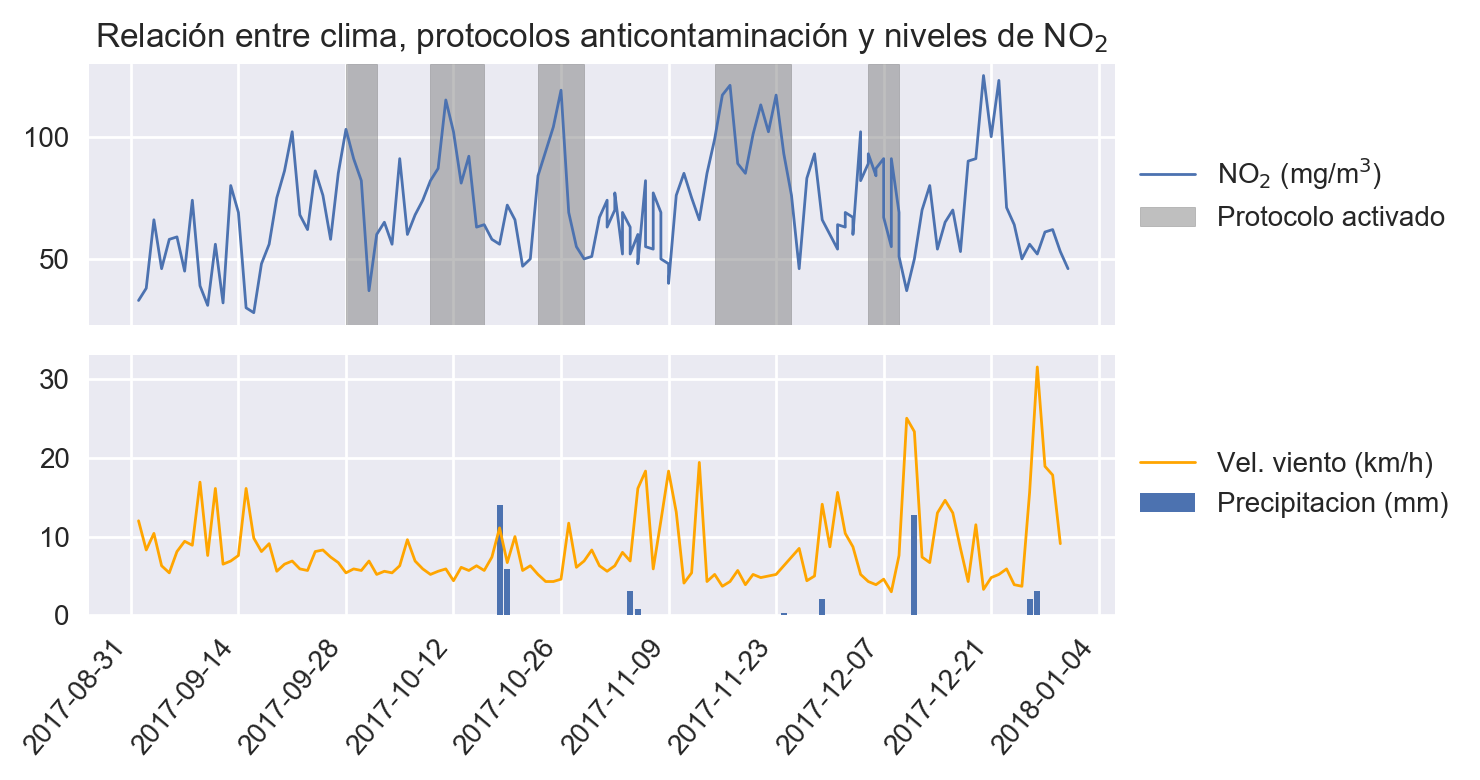

In [25]:
f, (ax2, ax1) = plt.subplots(2, 1, sharex=True)
f.set_dpi(200)

# Primer plot: datos de precipitación y viento
ax1.bar(tiempo_Sept_Dic_2017['Fecha'].values, 
        tiempo_Sept_Dic_2017['Precipit'], 
        linewidth=1, 
        label='Precipitacion (mm)')

ax1.plot(tiempo_Sept_Dic_2017['Fecha'], 
         tiempo_Sept_Dic_2017['Vel_Viento'], 
         linewidth=1,
         label='Vel. viento (km/h)',
         color='orange'
        )

ax2.set_title('Relación entre clima, protocolos anticontaminación y niveles de NO$_2$');
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Segundo plot: niveles de NO2 y protocolos anticontaminación
ax2.plot(calidad_NO2_2017_escuelas.index,
         calidad_NO2_2017_escuelas.values,
         linewidth=1, 
         label='NO$_2$ (mg/m$^3$)')

# Marco con un sombreado gris los 5 periodos en los que estuvo activo el protocolo anticontaminación:
ax2.axvspan(*mdates.datestr2num(['09/28/2017', '10/02/2017']), color='gray', alpha=0.5, label='Protocolo activado')
ax2.axvspan(*mdates.datestr2num(['10/09/2017', '10/16/2017']), color='gray', alpha=0.5)
ax2.axvspan(*mdates.datestr2num(['10/23/2017', '10/29/2017']), color='gray', alpha=0.5)
ax2.axvspan(*mdates.datestr2num(['11/15/2017', '11/25/2017']), color='gray', alpha=0.5)
ax2.axvspan(*mdates.datestr2num(['12/5/2017',  '12/9/2017']), color='gray', alpha=0.5)

f.autofmt_xdate(rotation=50, ha='right')
f.tight_layout() 

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Estas son algunas de las conclusiones que podemos obtener a la vista del gráfico:
- Las medidas del protocolo anticontaminación parecen tener un efecto significativo en la concentración de NO$_2$. En las zonas sombreadas en gris del primer gráfico se observa que tras cada episodio se consigue controlar los niveles y disminuirlos a un valor inferior al que tenían antes de la activación.
- La presencia de la lluvia o el viento ayudan a mejorar la calidad del aire. Los picos en la velocidad del viento coinciden con mínimos en la concentración de NO$_2$.

Como nota adicional, podemos destacar que durante el último pico en la concentración de NO$_2$ no se activó el protocolo anticontaminación. En el caso de este contaminante, la activación sólo se produce cuando en tres estaciones cualesquiera de una misma zona se superan los 400 $\mu$g/m$^3$ durante tres horas consecutivas. Nuestro dataset sólo contiene una medida por día, con lo que no podemos realizar un análisis horario. En cualquier caso, y dado que no se activó el protocolo, podemos concluir que las condiciones necesarias para la activación no se cumplieron en otras dos estaciones.

## Conclusiones y notas finales <a name="conclusiones"></a>
El incremento de episodios de alta contaminación durante los últimos años ha provocado una mayor demanda de los datos de cara al estudio y monitorización de los diferentes contaminantes. La web de calidad del aire del Ayuntamiento de Madrid ofrece unos datasets muy completos con los que se pueden realizar análisis muy avanzados, si bien requieren mucho trabajo de limpieza y preparación. 

En este trabajo hemos seleccionado los datos históricos diarios, aunque el ayuntamiento también pone a nuestra disposición los datos históricos horarios e incluso los datos en tiempo real, que se pueden consultar a través de una API REST.